# Metropolis Algorithm: Theory and Implementation from Scratch

## Introduction

The Metropolis algorithm is one of the oldest and most fundamental Markov Chain Monte Carlo (MCMC) methods. Developed by Nicholas Metropolis and colleagues in 1953, it provides a way to sample from probability distributions where direct sampling is difficult or impossible.

In this notebook, we will:
1. Explore the theoretical foundations of the Metropolis algorithm
2. Implement the algorithm from scratch in Python
3. Apply it to sample from multivariate normal distributions
4. Extend it to a Bayesian linear regression problem
5. Analyze the algorithm's performance and limitations

Let's begin by importing the necessary libraries.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from tqdm.notebook import tqdm

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

## 1. Theoretical Background

### 1.1 The Metropolis Algorithm

The Metropolis algorithm is designed to sample from a target probability distribution $\pi(x)$ when we only know the distribution up to a normalizing constant. That is, we know $\pi(x) \propto f(x)$, where $f(x)$ is a function we can evaluate, but we don't know the normalizing constant that would make $\pi(x)$ integrate to 1.

The algorithm works by constructing a Markov chain whose stationary distribution is the target distribution $\pi(x)$. It does this through a proposal-acceptance mechanism:

1. Start with an initial state $x_0$
2. For each iteration $t$:
   - a. Propose a new state $x'$ from a symmetric proposal distribution $q(x'|x_t)$
   - b. Calculate the acceptance ratio $\alpha = \min\left(1, \frac{\pi(x')}{\pi(x_t)}\right)$
   - c. Generate a uniform random number $u \sim \text{Uniform}(0,1)$
   - d. If $u < \alpha$, accept the proposal: $x_{t+1} = x'$
   - e. Otherwise, reject and stay: $x_{t+1} = x_t$

### 1.2 Key Properties

- **Symmetric Proposal**: The Metropolis algorithm requires that the proposal distribution is symmetric, meaning $q(x'|x) = q(x|x')$. A common choice is a Gaussian centered at the current state.

- **Detailed Balance**: The acceptance criterion ensures that the Markov chain satisfies detailed balance, which guarantees that $\pi(x)$ is the stationary distribution of the chain.

- **Ergodicity**: Under mild conditions, the chain is ergodic, meaning it will eventually explore the entire state space and converge to the target distribution regardless of the starting point.

- **Acceptance Rate**: The efficiency of the algorithm depends on the acceptance rate, which is influenced by the proposal distribution. If the proposals are too conservative, the chain will move slowly; if they're too aggressive, most proposals will be rejected.

### 1.3 Practical Considerations

- **Burn-in Period**: Initial samples are discarded to allow the chain to reach its stationary distribution.

- **Thinning**: To reduce autocorrelation, we might keep only every $k$-th sample.

- **Multiple Chains**: Running multiple chains from different starting points helps assess convergence.

- **Proposal Tuning**: The scale of the proposal distribution affects the acceptance rate and efficiency.

Now, let's implement the Metropolis algorithm from scratch.

## 2. Implementation from Scratch

We'll start by implementing a general Metropolis sampler that can work with any target distribution.

In [1]:
def metropolis_sampler(log_prob_func, initial_state, n_samples, proposal_std, burn_in=0, thin=1):
    """
    Metropolis algorithm for sampling from a probability distribution.
    
    Parameters:
    -----------
    log_prob_func : function
        Function that computes the log probability of a state
    initial_state : array-like
        Initial state of the Markov chain
    n_samples : int
        Number of samples to generate
    proposal_std : float or array-like
        Standard deviation of the Gaussian proposal distribution
    burn_in : int, optional
        Number of initial samples to discard
    thin : int, optional
        Thinning factor (keep every thin-th sample)
        
    Returns:
    --------
    samples : array
        Generated samples
    acceptance_rate : float
        Fraction of proposals that were accepted
    """
    # Convert initial state to numpy array if it isn't already
    current_state = np.array(initial_state, dtype=float)
    dim = current_state.shape[0]  # Dimensionality of the state
    
    # Total number of iterations needed
    n_iterations = burn_in + thin * n_samples
    
    # Initialize storage for samples and acceptance tracking
    samples = np.zeros((n_samples, dim))
    current_log_prob = log_prob_func(current_state)
    n_accepted = 0
    
    # Main sampling loop
    sample_idx = 0
    for i in tqdm(range(n_iterations), desc="Sampling"):
        # Propose a new state
        proposal = current_state + np.random.normal(0, proposal_std, size=dim)
        
        # Compute log probability of the proposed state
        proposal_log_prob = log_prob_func(proposal)
        
        # Compute log acceptance ratio
        log_acceptance_ratio = proposal_log_prob - current_log_prob
        
        # Accept or reject the proposal
        if np.log(np.random.random()) < log_acceptance_ratio:
            current_state = proposal
            current_log_prob = proposal_log_prob
            n_accepted += 1
        
        # Store the sample if past burn-in and due for storage based on thinning
        if i >= burn_in and (i - burn_in) % thin == 0:
            samples[sample_idx] = current_state
            sample_idx += 1
    
    # Compute acceptance rate
    acceptance_rate = n_accepted / n_iterations
    
    return samples, acceptance_rate

## 3. Example 1: Sampling from a Multivariate Normal Distribution

Let's apply our Metropolis sampler to a multivariate normal distribution. This is a good test case because:
1. We know the true distribution
2. We can easily calculate the density
3. We can visualize the results in 2D
4. It demonstrates how correlation affects sampling efficiency

We'll sample from a 2D normal distribution with mean $\mu = [0, 0]$ and covariance matrix $\Sigma = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}$, where $\rho$ is the correlation coefficient.

In [3]:
def multivariate_normal_log_pdf(x, mean, cov):
    """
    Compute the log PDF of a multivariate normal distribution.
    
    Parameters:
    -----------
    x : array-like
        Point at which to evaluate the PDF
    mean : array-like
        Mean vector of the distribution
    cov : array-like
        Covariance matrix of the distribution
        
    Returns:
    --------
    log_pdf : float
        Log probability density at x
    """
    x = np.array(x)
    mean = np.array(mean)
    cov = np.array(cov)
    dim = len(x)
    
    # Compute log determinant of covariance matrix
    sign, logdet = np.linalg.slogdet(cov)
    
    # Compute Mahalanobis distance
    diff = x - mean
    mahalanobis = diff.T @ np.linalg.inv(cov) @ diff
    
    # Compute log PDF
    log_pdf = -0.5 * (dim * np.log(2 * np.pi) + logdet + mahalanobis)
    
    return log_pdf

In [4]:
# Define parameters for the target distribution
mean = np.array([0, 0])
rho = 0.8  # Correlation coefficient
cov = np.array([[1, rho], [rho, 1]])

# Create a function that returns the log probability for our target distribution
def target_log_prob(x):
    return multivariate_normal_log_pdf(x, mean, cov)

# Set sampling parameters
initial_state = np.array([2, 2])  # Start away from the mean
n_samples = 5000
proposal_std = 0.5  # Standard deviation for the proposal distribution
burn_in = 1000
thin = 1

# Run the Metropolis sampler
samples, acceptance_rate = metropolis_sampler(
    target_log_prob, initial_state, n_samples, proposal_std, burn_in, thin
)

print(f"Acceptance rate: {acceptance_rate:.2f}")

Sampling:   0%|          | 0/6000 [00:00<?, ?it/s]

Acceptance rate: 0.64


Now, let's visualize the results to see how well our sampler approximates the target distribution.

In [5]:
def plot_2d_samples(samples, true_mean=None, true_cov=None, title="Samples"):
    """
    Plot 2D samples with marginal distributions and optionally compare to true distribution.
    
    Parameters:
    -----------
    samples : array-like
        2D samples to plot
    true_mean : array-like, optional
        True mean vector for comparison
    true_cov : array-like, optional
        True covariance matrix for comparison
    title : str, optional
        Plot title
    """
    # Create a figure with a grid for the joint and marginal plots
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 3],
                         wspace=0.05, hspace=0.05)
    
    # Joint distribution plot
    ax_joint = fig.add_subplot(gs[1, 0])
    
    # Plot the samples
    ax_joint.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=5)
    
    # If true distribution is provided, plot contours
    if true_mean is not None and true_cov is not None:
        # Create a grid of points
        x = np.linspace(-3, 3, 100)
        y = np.linspace(-3, 3, 100)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))
        
        # Compute PDF values on the grid
        rv = stats.multivariate_normal(true_mean, true_cov)
        Z = rv.pdf(pos)
        
        # Plot contours
        levels = np.linspace(0, Z.max(), 10)[1:]
        ax_joint.contour(X, Y, Z, levels=levels, colors='r', alpha=0.7)
    
    # Set labels and limits
    ax_joint.set_xlabel('$x_1$')
    ax_joint.set_ylabel('$x_2$')
    ax_joint.set_xlim(-3, 3)
    ax_joint.set_ylim(-3, 3)
    
    # Marginal distribution for x1
    ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
    sns.kdeplot(samples[:, 0], ax=ax_marg_x, fill=True)
    if true_mean is not None and true_cov is not None:
        x = np.linspace(-3, 3, 1000)
        ax_marg_x.plot(x, stats.norm.pdf(x, true_mean[0], np.sqrt(true_cov[0, 0])), 'r')
    ax_marg_x.set_yticks([])
    ax_marg_x.set_title(title)
    
    # Marginal distribution for x2
    ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)
    sns.kdeplot(y=samples[:, 1], ax=ax_marg_y, fill=True)
    if true_mean is not None and true_cov is not None:
        y = np.linspace(-3, 3, 1000)
        ax_marg_y.plot(stats.norm.pdf(y, true_mean[1], np.sqrt(true_cov[1, 1])), y, 'r')
    ax_marg_y.set_xticks([])
    
    # Turn off tick labels on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)
    
    plt.show()

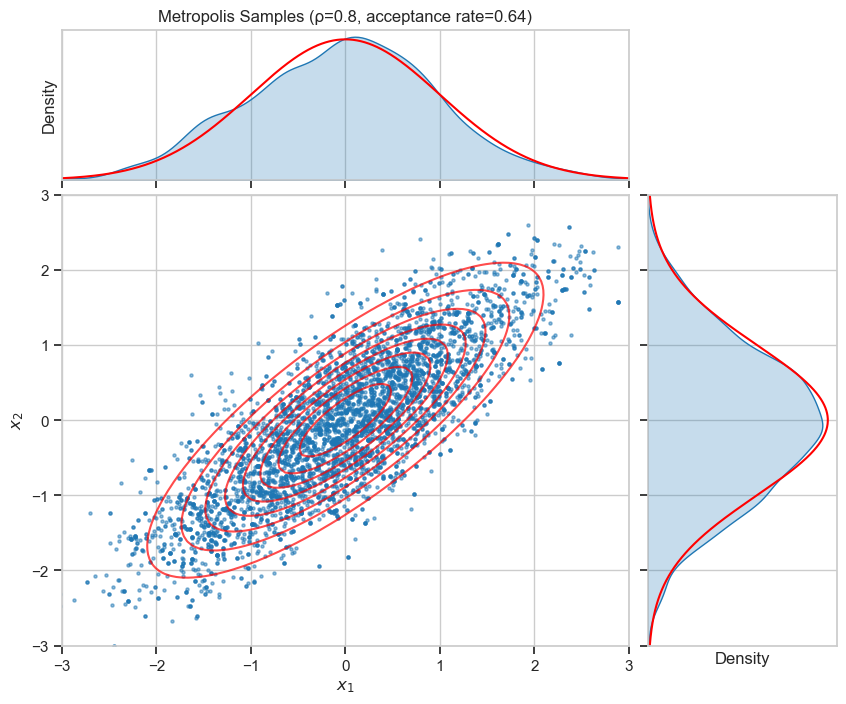

In [6]:
# Plot the samples
plot_2d_samples(samples, mean, cov, title=f"Metropolis Samples (ρ={rho}, acceptance rate={acceptance_rate:.2f})")

Let's also look at the trace plots and autocorrelation to assess mixing and convergence.

In [7]:
def plot_diagnostics(samples, parameter_names=None):
    """
    Plot trace plots and autocorrelation for MCMC samples.
    
    Parameters:
    -----------
    samples : array-like
        MCMC samples
    parameter_names : list, optional
        Names of the parameters
    """
    n_samples, dim = samples.shape
    
    if parameter_names is None:
        parameter_names = [f"$x_{i+1}$" for i in range(dim)]
    
    # Create figure
    fig, axes = plt.subplots(dim, 2, figsize=(12, 3*dim))
    
    # Plot trace and autocorrelation for each parameter
    for i in range(dim):
        # Trace plot
        axes[i, 0].plot(samples[:, i])
        axes[i, 0].set_title(f"Trace plot for {parameter_names[i]}")
        axes[i, 0].set_xlabel("Iteration")
        axes[i, 0].set_ylabel(parameter_names[i])
        
        # Autocorrelation plot
        lags = min(50, n_samples // 5)
        acf = np.zeros(lags)
        for lag in range(lags):
            acf[lag] = np.corrcoef(samples[lag:, i], samples[:-lag if lag > 0 else None, i])[0, 1]
        
        axes[i, 1].bar(range(lags), acf)
        axes[i, 1].set_title(f"Autocorrelation for {parameter_names[i]}")
        axes[i, 1].set_xlabel("Lag")
        axes[i, 1].set_ylabel("Autocorrelation")
    
    plt.tight_layout()
    plt.show()

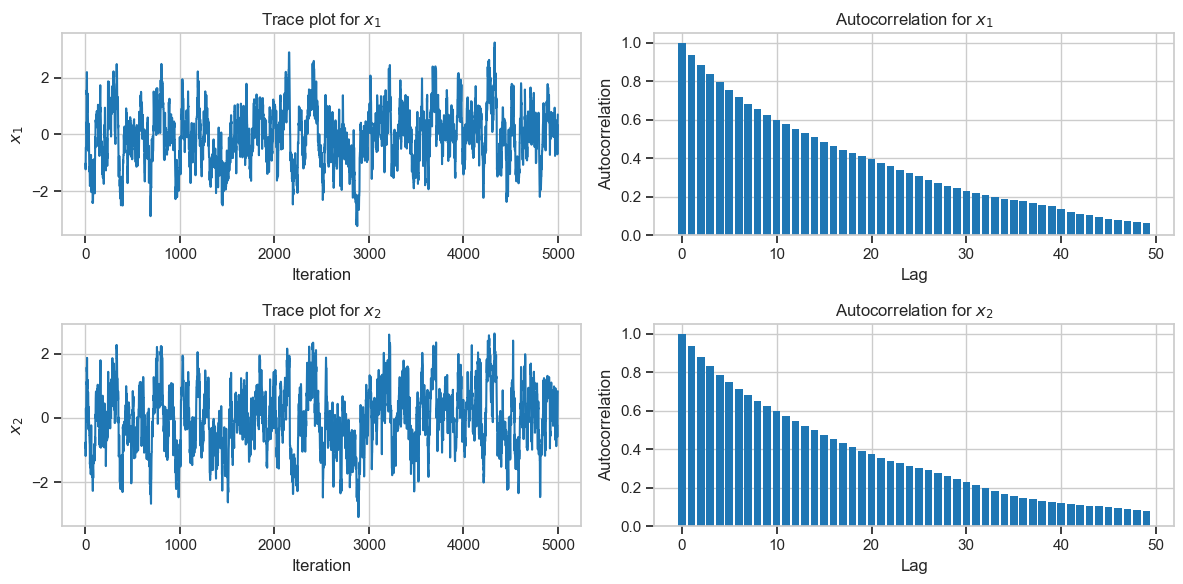

In [8]:
# Plot diagnostics
plot_diagnostics(samples)

### 3.1 Effect of Proposal Scale

The scale of the proposal distribution (the standard deviation of the Gaussian) has a significant impact on the efficiency of the Metropolis algorithm. Let's experiment with different proposal scales and see how they affect the acceptance rate and mixing.

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

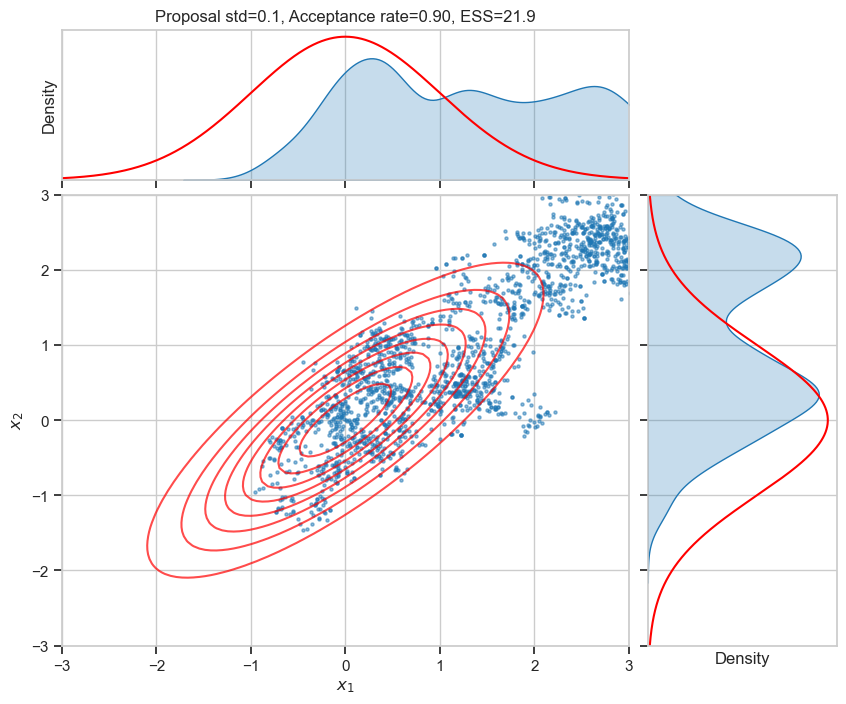

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

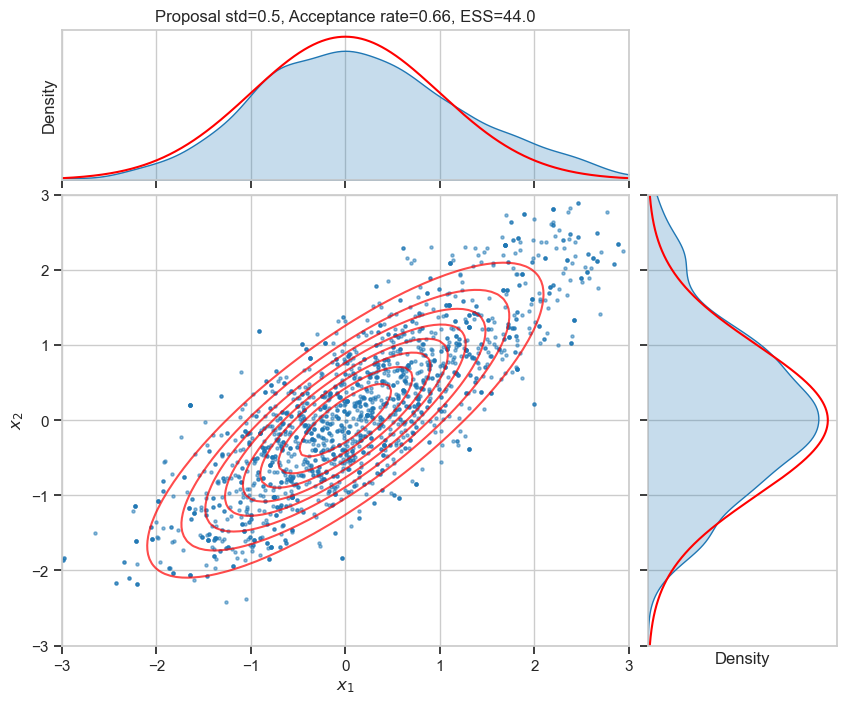

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

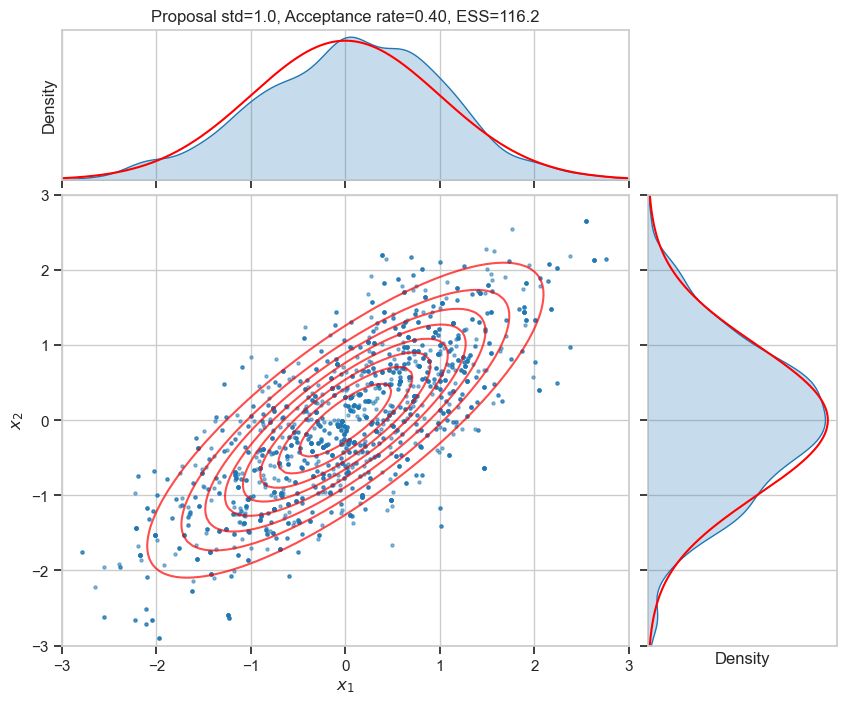

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

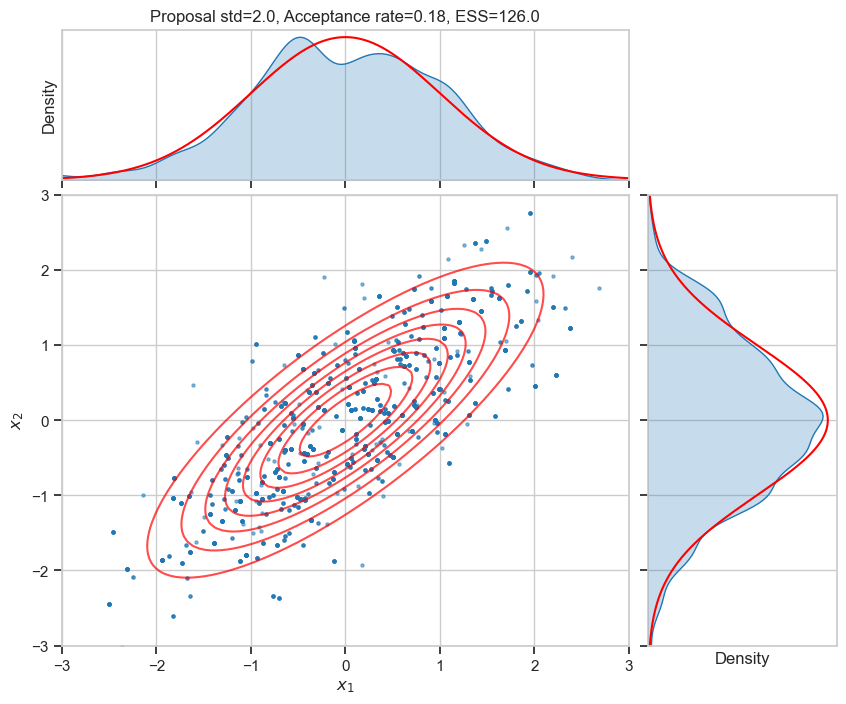

In [9]:
# Try different proposal scales
proposal_stds = [0.1, 0.5, 1.0, 2.0]
results = []

for std in proposal_stds:
    samples, acceptance_rate = metropolis_sampler(
        target_log_prob, initial_state, n_samples=2000, proposal_std=std, burn_in=500, thin=1
    )
    
    # Calculate effective sample size (ESS) using autocorrelation
    def calculate_ess(chain):
        n = len(chain)
        lags = min(50, n // 5)
        acf = np.zeros(lags)
        for lag in range(lags):
            acf[lag] = np.corrcoef(chain[lag:], chain[:-lag if lag > 0 else None])[0, 1]
        # Truncate at first negative autocorrelation
        neg_idx = np.where(acf < 0)[0]
        if len(neg_idx) > 0:
            acf = acf[:neg_idx[0]]
        # Calculate ESS
        ess = n / (1 + 2 * np.sum(acf[1:]))
        return ess
    
    ess_x1 = calculate_ess(samples[:, 0])
    ess_x2 = calculate_ess(samples[:, 1])
    ess_avg = (ess_x1 + ess_x2) / 2
    
    results.append({
        'proposal_std': std,
        'acceptance_rate': acceptance_rate,
        'ess_x1': ess_x1,
        'ess_x2': ess_x2,
        'ess_avg': ess_avg,
        'efficiency': ess_avg / 2000  # ESS per iteration
    })
    
    # Plot samples
    plot_2d_samples(samples, mean, cov, 
                   title=f"Proposal std={std}, Acceptance rate={acceptance_rate:.2f}, ESS={ess_avg:.1f}")

In [10]:
# Summarize results
results_df = pd.DataFrame(results)
results_df

,proposal_std,acceptance_rate,ess_x1,ess_x2,ess_avg,efficiency
0,0.1,0.9048,21.744158,22.144486,21.944322,0.010972
1,0.5,0.6552,42.801772,45.227821,44.014797,0.022007
2,1.0,0.4040,119.836522,112.572709,116.204615,0.058102
3,2.0,0.1820,115.615193,136.387973,126.001583,0.063001


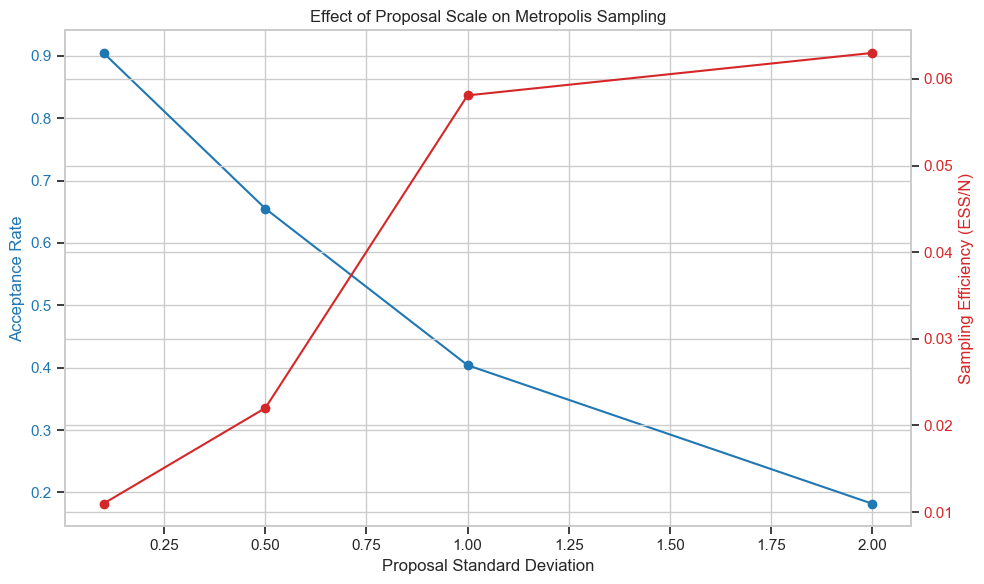

In [11]:
# Plot acceptance rate and efficiency vs proposal scale
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Proposal Standard Deviation')
ax1.set_ylabel('Acceptance Rate', color='tab:blue')
ax1.plot(results_df['proposal_std'], results_df['acceptance_rate'], 'o-', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Sampling Efficiency (ESS/N)', color='tab:red')
ax2.plot(results_df['proposal_std'], results_df['efficiency'], 'o-', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Effect of Proposal Scale on Metropolis Sampling')
fig.tight_layout()
plt.show()

### 3.2 Effect of Correlation

The correlation in the target distribution also affects the efficiency of the Metropolis algorithm. Let's experiment with different correlation values.

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

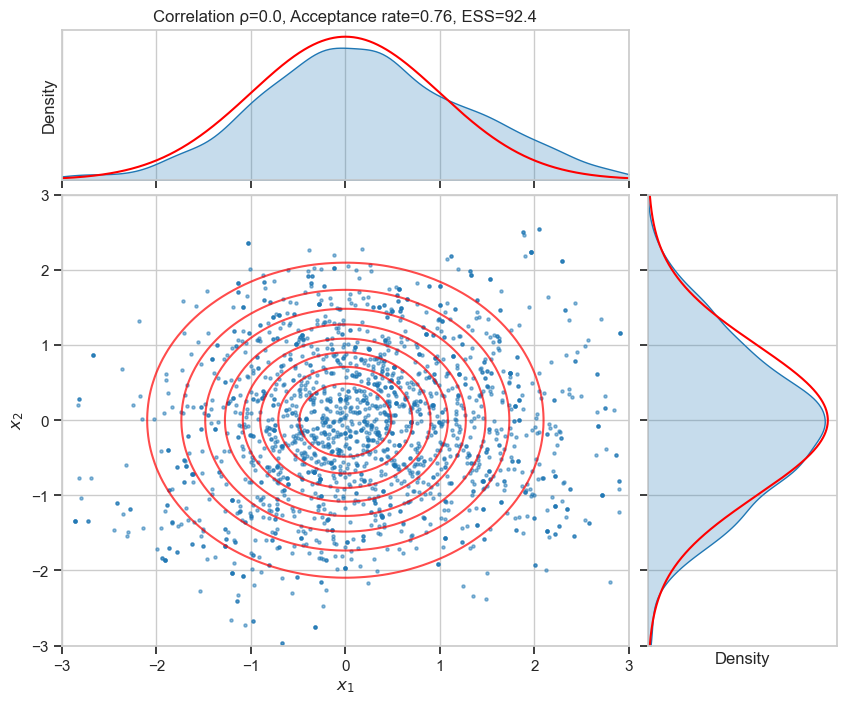

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

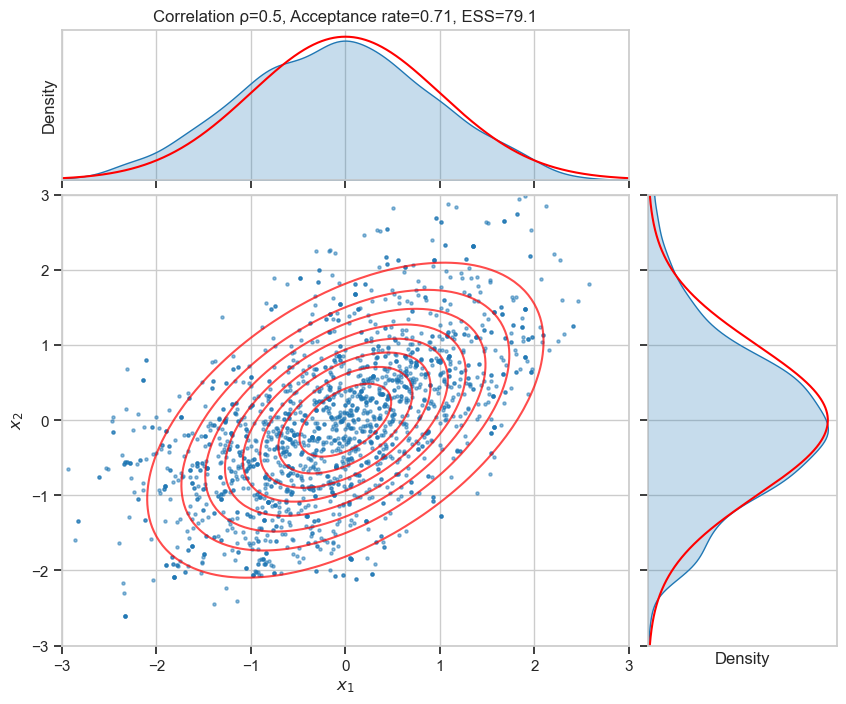

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

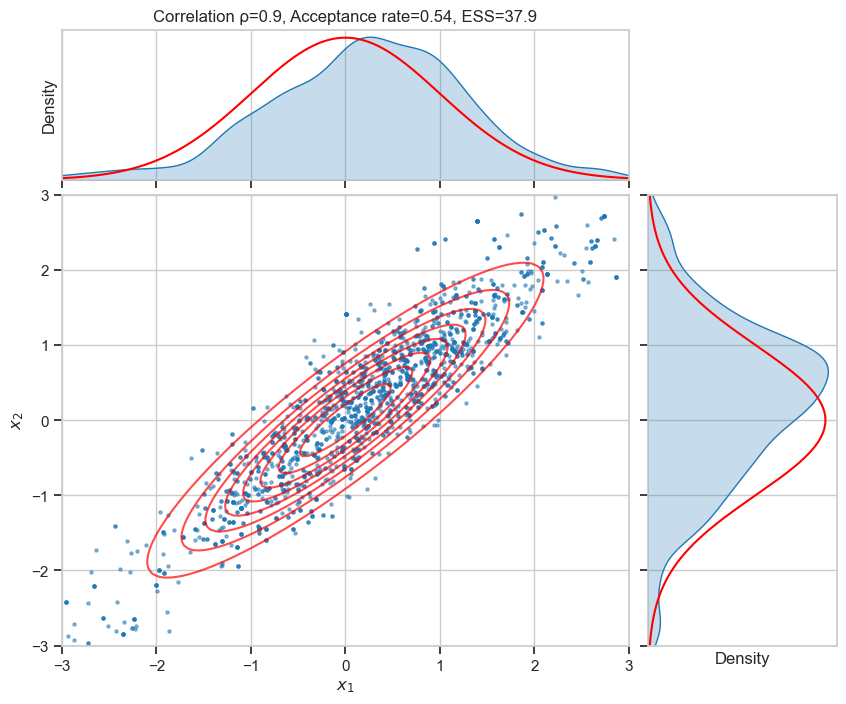

Sampling:   0%|          | 0/2500 [00:00<?, ?it/s]

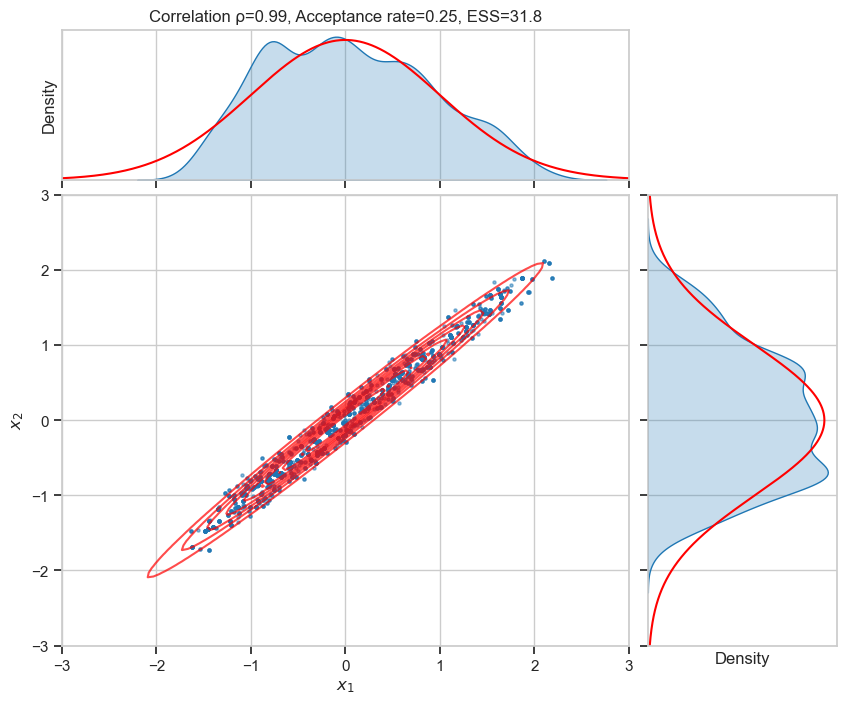

In [12]:
# Try different correlation values
rho_values = [0.0, 0.5, 0.9, 0.99]
corr_results = []

for rho in rho_values:
    # Update covariance matrix
    cov = np.array([[1, rho], [rho, 1]])
    
    # Update target log probability function
    def target_log_prob(x, mean=mean, cov=cov):
        return multivariate_normal_log_pdf(x, mean, cov)
    
    # Run sampler
    samples, acceptance_rate = metropolis_sampler(
        target_log_prob, initial_state, n_samples=2000, proposal_std=0.5, burn_in=500, thin=1
    )
    
    # Calculate effective sample size
    ess_x1 = calculate_ess(samples[:, 0])
    ess_x2 = calculate_ess(samples[:, 1])
    ess_avg = (ess_x1 + ess_x2) / 2
    
    corr_results.append({
        'rho': rho,
        'acceptance_rate': acceptance_rate,
        'ess_avg': ess_avg,
        'efficiency': ess_avg / 2000
    })
    
    # Plot samples
    plot_2d_samples(samples, mean, cov, 
                   title=f"Correlation ρ={rho}, Acceptance rate={acceptance_rate:.2f}, ESS={ess_avg:.1f}")

In [13]:
# Summarize correlation results
corr_results_df = pd.DataFrame(corr_results)
corr_results_df

,rho,acceptance_rate,ess_avg,efficiency
0,0.00,0.7648,92.400441,0.046200
1,0.50,0.7132,79.138340,0.039569
2,0.90,0.5408,37.927053,0.018964
3,0.99,0.2464,31.758128,0.015879


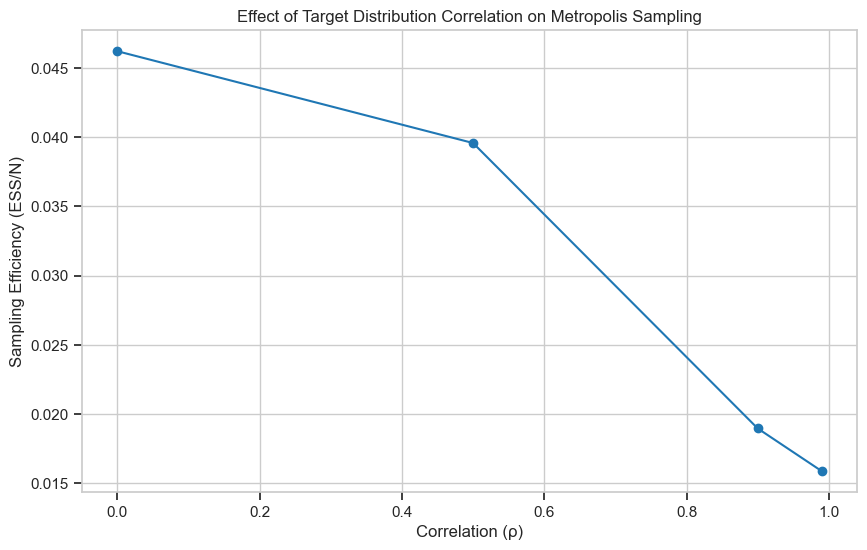

In [14]:
# Plot efficiency vs correlation
plt.figure(figsize=(10, 6))
plt.plot(corr_results_df['rho'], corr_results_df['efficiency'], 'o-')
plt.xlabel('Correlation (ρ)')
plt.ylabel('Sampling Efficiency (ESS/N)')
plt.title('Effect of Target Distribution Correlation on Metropolis Sampling')
plt.grid(True)
plt.show()

## 4. Example 2: Bayesian Linear Regression

Now, let's apply the Metropolis algorithm to a more practical problem: Bayesian linear regression. In this example, we'll:
1. Generate synthetic data from a linear model with noise
2. Define priors on the parameters
3. Sample from the posterior distribution using our Metropolis sampler
4. Analyze the results and make predictions

### 4.1 Generate Synthetic Data

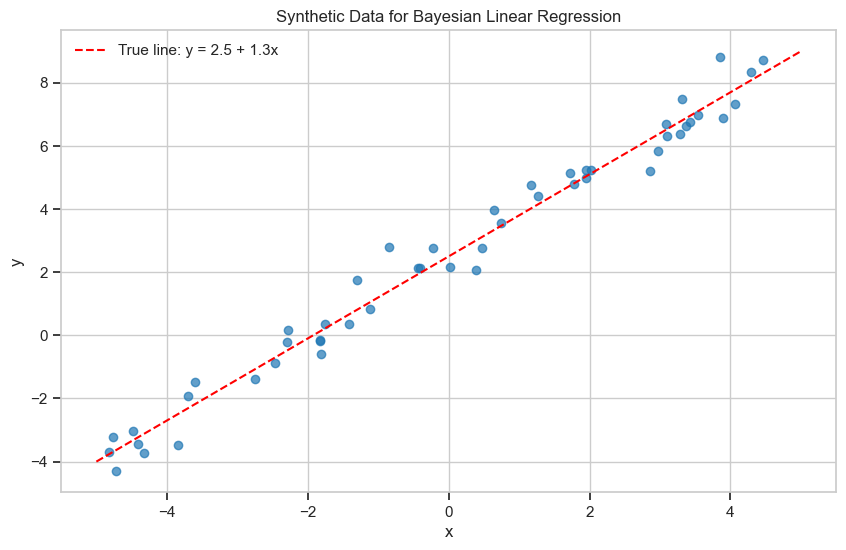

In [18]:
# Set true parameter values
true_intercept = 2.5
true_slope = 1.3
true_noise_std = 0.5

# Generate synthetic data
n_data = 50
x_data = np.random.uniform(-5, 5, n_data)
y_data = true_intercept + true_slope * x_data + np.random.normal(0, true_noise_std, n_data)

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, alpha=0.7)
plt.plot([-5, 5], [true_intercept - 5*true_slope, true_intercept + 5*true_slope], 'r--', 
         label=f'True line: y = {true_intercept} + {true_slope}x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data for Bayesian Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

### 4.2 Define the Bayesian Model

In Bayesian linear regression, we model:

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)$$

We need to define priors for the parameters $\beta_0$ (intercept), $\beta_1$ (slope), and $\sigma$ (noise standard deviation). Then, we'll sample from the posterior distribution:

$$p(\beta_0, \beta_1, \sigma | \mathbf{x}, \mathbf{y}) \propto p(\mathbf{y} | \mathbf{x}, \beta_0, \beta_1, \sigma) \cdot p(\beta_0) \cdot p(\beta_1) \cdot p(\sigma)$$

Let's use the following priors:
- $\beta_0 \sim \mathcal{N}(0, 10)$
- $\beta_1 \sim \mathcal{N}(0, 10)$
- $\sigma \sim \text{HalfNormal}(5)$

In [19]:
def linear_regression_log_posterior(params, x, y):
    """
    Compute the log posterior for Bayesian linear regression.
    
    Parameters:
    -----------
    params : array-like
        [intercept, slope, log_sigma]
    x : array-like
        Predictor variable
    y : array-like
        Response variable
        
    Returns:
    --------
    log_posterior : float
        Log posterior probability
    """
    intercept, slope, log_sigma = params
    sigma = np.exp(log_sigma)  # Work with log(sigma) for unconstrained sampling
    
    # Prior log probabilities
    log_prior_intercept = stats.norm.logpdf(intercept, 0, 10)
    log_prior_slope = stats.norm.logpdf(slope, 0, 10)
    log_prior_sigma = stats.halfnorm.logpdf(sigma, scale=5) + log_sigma  # Jacobian adjustment
    
    # Likelihood
    predicted = intercept + slope * x
    log_likelihood = np.sum(stats.norm.logpdf(y, predicted, sigma))
    
    # Posterior
    log_posterior = log_prior_intercept + log_prior_slope + log_prior_sigma + log_likelihood
    
    return log_posterior

### 4.3 Sample from the Posterior

In [20]:
# Create a function that returns the log posterior for our data
def target_log_posterior(params):
    return linear_regression_log_posterior(params, x_data, y_data)

# Set sampling parameters
initial_state = np.array([0.0, 0.0, 0.0])  # [intercept, slope, log_sigma]
n_samples = 5000
proposal_std = np.array([0.3, 0.3, 0.1])  # Different scales for different parameters
burn_in = 1000
thin = 2

# Run the Metropolis sampler
posterior_samples, acceptance_rate = metropolis_sampler(
    target_log_posterior, initial_state, n_samples, proposal_std, burn_in, thin
)

print(f"Acceptance rate: {acceptance_rate:.2f}")

# Convert log_sigma to sigma
posterior_samples[:, 2] = np.exp(posterior_samples[:, 2])

Sampling:   0%|          | 0/11000 [00:00<?, ?it/s]

Acceptance rate: 0.04


### 4.4 Analyze the Results

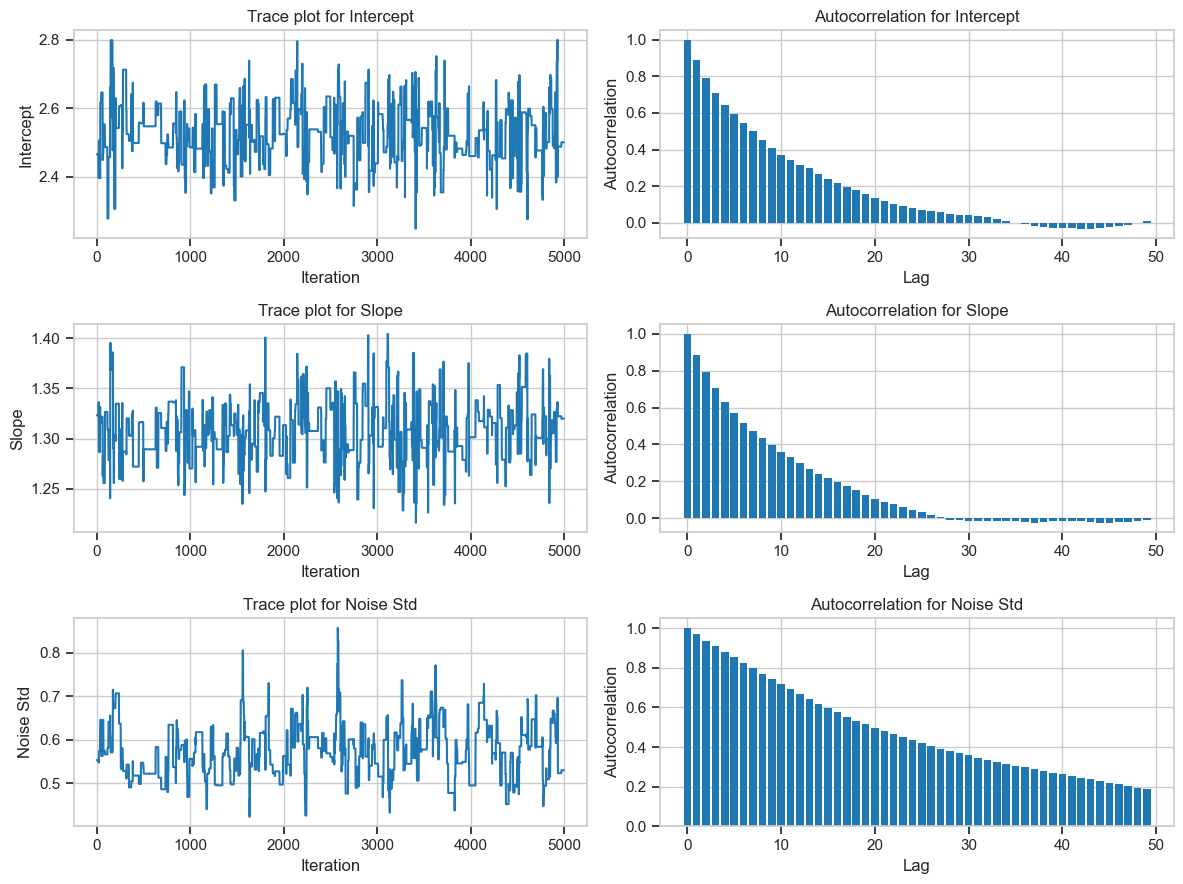

In [21]:
# Plot diagnostics
plot_diagnostics(posterior_samples, parameter_names=['Intercept', 'Slope', 'Noise Std'])

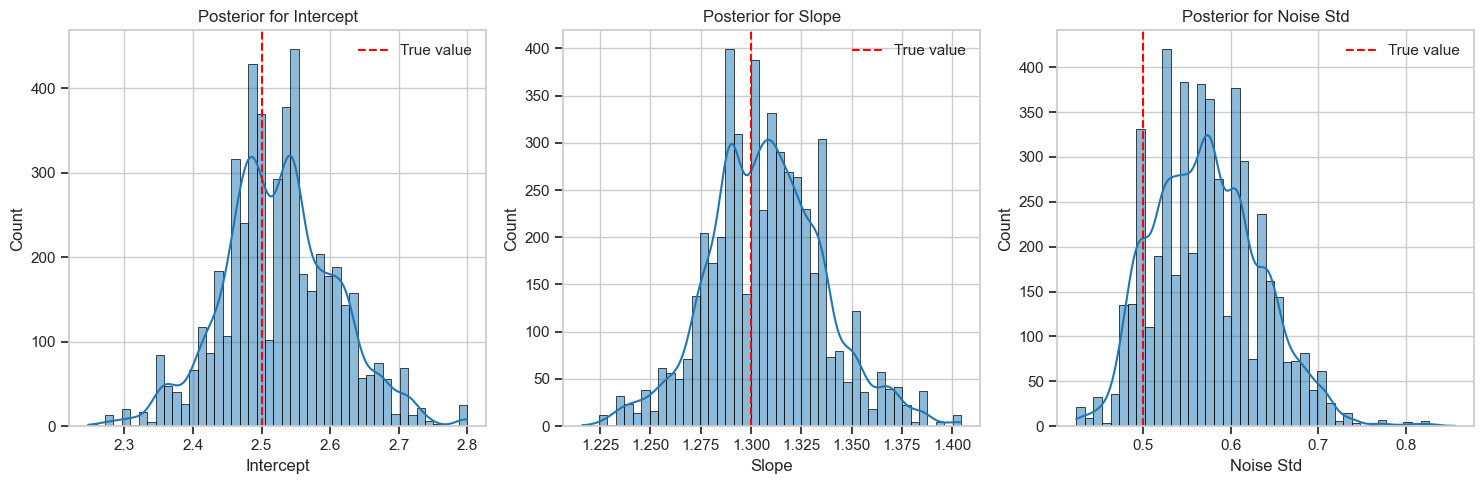

In [22]:
# Plot posterior distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Intercept
sns.histplot(posterior_samples[:, 0], kde=True, ax=axes[0])
axes[0].axvline(true_intercept, color='r', linestyle='--', label='True value')
axes[0].set_title('Posterior for Intercept')
axes[0].set_xlabel('Intercept')
axes[0].legend()

# Slope
sns.histplot(posterior_samples[:, 1], kde=True, ax=axes[1])
axes[1].axvline(true_slope, color='r', linestyle='--', label='True value')
axes[1].set_title('Posterior for Slope')
axes[1].set_xlabel('Slope')
axes[1].legend()

# Noise std
sns.histplot(posterior_samples[:, 2], kde=True, ax=axes[2])
axes[2].axvline(true_noise_std, color='r', linestyle='--', label='True value')
axes[2].set_title('Posterior for Noise Std')
axes[2].set_xlabel('Noise Std')
axes[2].legend()

plt.tight_layout()
plt.show()

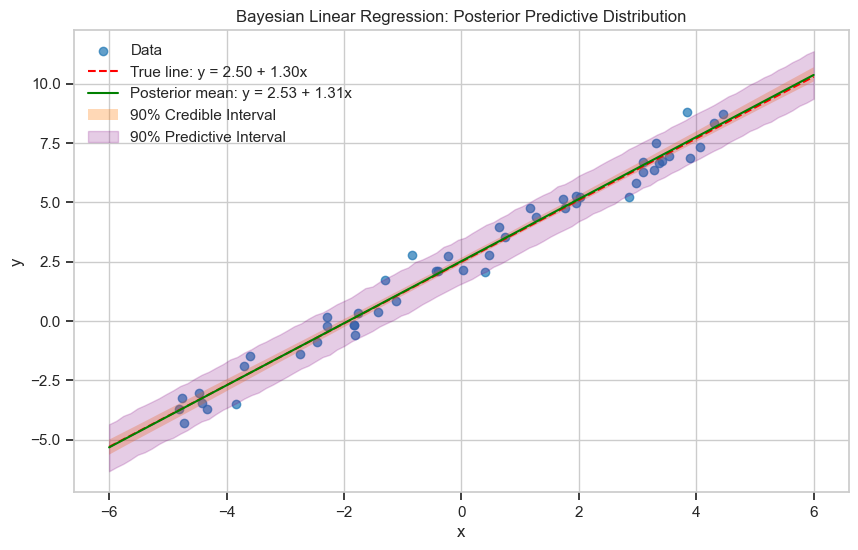

In [23]:
# Plot posterior predictive distribution
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(x_data, y_data, alpha=0.7, label='Data')

# Plot true line
x_range = np.linspace(-6, 6, 100)
plt.plot(x_range, true_intercept + true_slope * x_range, 'r--', 
         label=f'True line: y = {true_intercept:.2f} + {true_slope:.2f}x')

# Plot posterior mean line
mean_intercept = np.mean(posterior_samples[:, 0])
mean_slope = np.mean(posterior_samples[:, 1])
plt.plot(x_range, mean_intercept + mean_slope * x_range, 'g-', 
         label=f'Posterior mean: y = {mean_intercept:.2f} + {mean_slope:.2f}x')

# Plot credible intervals for the regression line
n_pred = 100
pred_x = np.linspace(-6, 6, n_pred)
pred_y = np.zeros((len(posterior_samples), n_pred))

for i, sample in enumerate(posterior_samples):
    intercept, slope, sigma = sample
    pred_y[i, :] = intercept + slope * pred_x

# Compute credible intervals
y_mean = np.mean(pred_y, axis=0)
y_5 = np.percentile(pred_y, 5, axis=0)
y_95 = np.percentile(pred_y, 95, axis=0)

# Plot credible interval for the regression line
plt.fill_between(pred_x, y_5, y_95, alpha=0.3, label='90% Credible Interval')

# Add predictive intervals (includes noise)
pred_y_with_noise = np.zeros((len(posterior_samples), n_pred))
for i, sample in enumerate(posterior_samples):
    intercept, slope, sigma = sample
    mean_pred = intercept + slope * pred_x
    pred_y_with_noise[i, :] = np.random.normal(mean_pred, sigma)

y_5_with_noise = np.percentile(pred_y_with_noise, 5, axis=0)
y_95_with_noise = np.percentile(pred_y_with_noise, 95, axis=0)

plt.fill_between(pred_x, y_5_with_noise, y_95_with_noise, alpha=0.2, color='purple', 
                 label='90% Predictive Interval')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian Linear Regression: Posterior Predictive Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Summarize posterior statistics
posterior_summary = pd.DataFrame({
    'Parameter': ['Intercept', 'Slope', 'Noise Std'],
    'True Value': [true_intercept, true_slope, true_noise_std],
    'Posterior Mean': np.mean(posterior_samples, axis=0),
    'Posterior Median': np.median(posterior_samples, axis=0),
    'Posterior Std': np.std(posterior_samples, axis=0),
    '5% Quantile': np.percentile(posterior_samples, 5, axis=0),
    '95% Quantile': np.percentile(posterior_samples, 95, axis=0)
})

posterior_summary

,Parameter,True Value,Posterior Mean,Posterior Median,Posterior Std,5% Quantile,95% Quantile
0,Intercept,2.5,2.526351,2.523950,0.083331,2.392908,2.669183
1,Slope,1.3,1.307676,1.307526,0.028485,1.260808,1.354734
2,Noise Std,0.5,0.572735,0.570245,0.060713,0.484016,0.680328


## 5. Limitations and Extensions of the Metropolis Algorithm

### 5.1 Limitations

The Metropolis algorithm, while powerful, has several limitations:

1. **Random Walk Behavior**: The algorithm exhibits random walk behavior, which can make it inefficient in high dimensions or when parameters are highly correlated.

2. **Tuning Required**: The proposal distribution needs to be carefully tuned. If the step size is too small, the chain moves slowly; if it's too large, the acceptance rate becomes too low.

3. **Symmetric Proposal Requirement**: The original Metropolis algorithm requires a symmetric proposal distribution.

4. **Difficulty with Multimodal Distributions**: The algorithm can get stuck in one mode of a multimodal distribution.

5. **Curse of Dimensionality**: As the dimension increases, the algorithm becomes less efficient.

### 5.2 Extensions and Alternatives

Several extensions and alternatives address these limitations:

1. **Metropolis-Hastings**: Generalizes the Metropolis algorithm to allow for asymmetric proposal distributions.

2. **Adaptive Metropolis**: Automatically tunes the proposal distribution based on the history of the chain.

3. **Gibbs Sampling**: Updates one parameter at a time, which can be more efficient when conditional distributions are known.

4. **Hamiltonian Monte Carlo (HMC)**: Uses gradient information to propose more distant states, reducing random walk behavior.

5. **No-U-Turn Sampler (NUTS)**: An adaptive version of HMC that automatically tunes the number of leapfrog steps.

6. **Parallel Tempering**: Runs multiple chains at different "temperatures" to better explore multimodal distributions.

## 6. Conclusion

In this notebook, we've explored the Metropolis algorithm, one of the foundational MCMC methods. We've implemented it from scratch and applied it to sample from multivariate normal distributions and to perform Bayesian linear regression.

Key takeaways:

1. The Metropolis algorithm allows us to sample from complex probability distributions when we only know them up to a normalizing constant.

2. The efficiency of the algorithm depends on the proposal distribution and the structure of the target distribution.

3. Diagnostics like trace plots and autocorrelation are essential for assessing convergence and mixing.

4. The algorithm can be applied to practical problems like Bayesian inference, but it has limitations in high dimensions or with complex geometries.

In the next notebooks, we'll explore more advanced MCMC methods like Gibbs sampling and Hamiltonian Monte Carlo, which address some of the limitations of the Metropolis algorithm.